In [1]:
import pandas as pd
import os
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.engine.input_layer import Input
from keras.layers import Dense, Concatenate
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.initializers import RandomNormal
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop

import random
random.seed(42)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc


Using TensorFlow backend.


In [2]:
#setting the home dir of the project and the dir of the data
proj_dir = "/capstone_project/"
data_dir = "/capstone_project/data/"
!mkdir -p "{proj_dir}"
!mkdir -p "{data_dir}"
!mkdir -p "{proj_dir}saved_models/"

#to use kaggle api
from google.colab import files
files.upload() #upload kaggle.json token file in ~/.kaggle/
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the data
!kaggle competitions download -c histopathologic-cancer-detection --force

#unzip training data
!mkdir -p "{data_dir}train/"
!unzip -q train.zip -d "{data_dir}train/"
#unzip train labels
!mkdir -p "{data_dir}"
!unzip -q train_labels.csv.zip -d "{data_dir}"

print("\ntotal number of images = {}".format(len(os.listdir(data_dir + "train/"))))

#divide data to train and test folders (80%, 20%) and sort images into subfolders : 0 and 1
#
!mkdir -p "{data_dir}test/"
#create subfolders
!mkdir -p "{data_dir}train/0"
!mkdir -p "{data_dir}train/1"
!mkdir -p "{data_dir}test/0"
!mkdir -p "{data_dir}test/1"

labels = pd.read_csv(data_dir + "train_labels.csv")

#move each image to the it's subfolder
src = data_dir + "train/"
train_dst_0 = data_dir + "train/0/"
train_dst_1 = data_dir + "train/1/"
test_dst_0 = data_dir + "test/0/"
test_dst_1 = data_dir + "test/1/"

for file_id, label in labels.values:
  if np.random.rand(1) < 0.2:
    if label == 0:
      os.rename(src + file_id + ".tif", test_dst_0 + file_id + ".tif")
    elif label == 1:
      os.rename(src + file_id + ".tif", test_dst_1 + file_id + ".tif")
  else:    
    if label == 0:
      os.rename(src + file_id + ".tif", train_dst_0 + file_id + ".tif")
    else:
      os.rename(src + file_id + ".tif", train_dst_1 + file_id + ".tif")
    
print("\nnumber of training images[0:{}, 1:{}]".format(len(os.listdir(data_dir + "train/0/")), len(os.listdir(data_dir + "train/1/"))))
print("\nnumber of test images[0:{}, 1:{}]".format(len(os.listdir(data_dir + "test/0/")), len(os.listdir(data_dir + "test/1/"))))

Saving kaggle.json to kaggle.json
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 90.1MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 84.1MB/s]
 99% 1.29G/1.30G [00:08<00:00, 217MB/s]
100% 1.30G/1.30G [00:08<00:00, 164MB/s]
100% 4.98G/4.98G [01:08<00:00, 133MB/s]
100% 4.98G/4.98G [01:08<00:00, 77.9MB/s]

total number of images = 220025

number of training images[0:104686, 1:71477]

number of test images[0:26222, 1:17640]



negative samples:


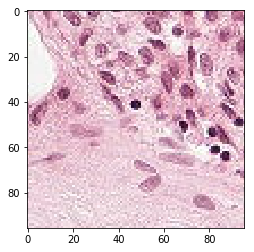

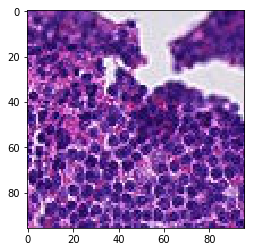

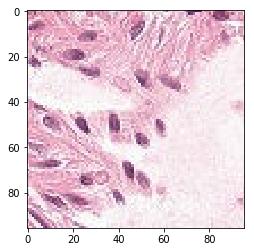


positive samples:


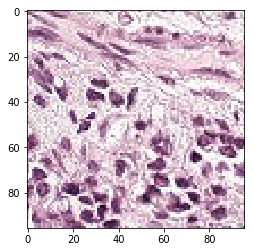

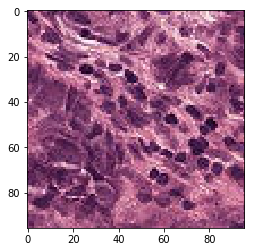

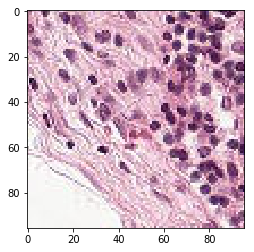

In [3]:
# random samples from the dataset
print("\nnegative samples:")
for i in range(1,4):
  image = os.listdir(data_dir + "train/0/")[random.randrange(len(os.listdir(data_dir + "train/0/")))]
  img=mpimg.imread(data_dir + "train/0/" + image)
  imgplot = plt.imshow(img)
  plt.show()
  
print("\npositive samples:")
for i in range(1,4):
  image = os.listdir(data_dir + "train/1/")[random.randrange(len(os.listdir(data_dir + "train/1/")))]
  img=mpimg.imread(data_dir + "train/1/" + image)
  imgplot = plt.imshow(img)
  plt.show()

In [4]:
#image normalization and augmentation
#in this step I also split the training data into training\validation (0.75\0.25)
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=180, 
                             width_shift_range=0.15, 
                             height_shift_range=0.15, 
                             zoom_range=0.25, 
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             validation_split=0.25)

train_datagen = datagen.flow_from_directory(data_dir + "train/", 
                                            target_size=(96, 96), 
                                            batch_size=100, 
                                            class_mode="binary", 
                                            subset="training")

validation_datagen = datagen.flow_from_directory(data_dir + "train/", 
                                                 target_size=(96, 96), 
                                                 batch_size=100, 
                                                 class_mode="binary", 
                                                 subset="validation")

test_datagen = ImageDataGenerator(rescale=1./255
                                 ).flow_from_directory(data_dir + "test/", 
                                                       target_size=(96, 96), 
                                                       batch_size=100, 
                                                       class_mode="binary", 
                                                       shuffle=False)

Found 132123 images belonging to 2 classes.
Found 44040 images belonging to 2 classes.
Found 43862 images belonging to 2 classes.


training images example after preprocessing:
class:0.0


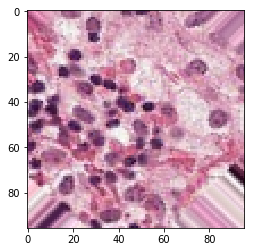

class:0.0


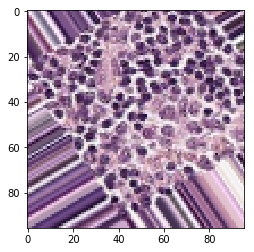

class:0.0


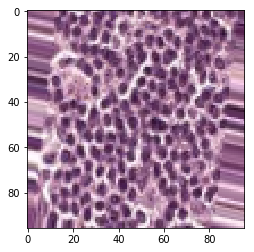

validation images example after preprocessing:
class:1.0


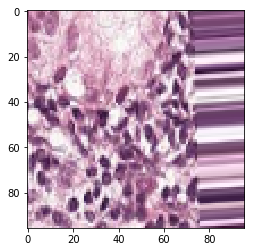

class:0.0


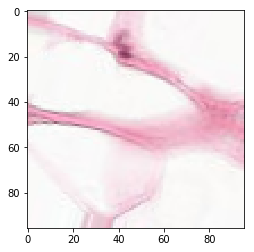

class:1.0


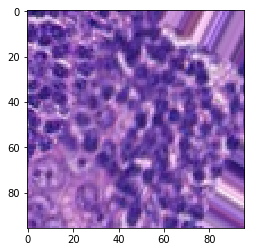

test images example after preprocessing:
class:0.0


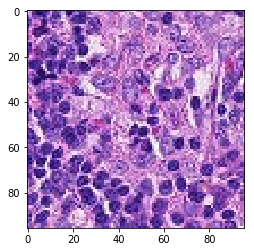

class:0.0


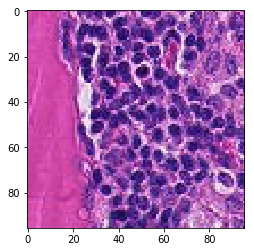

class:0.0


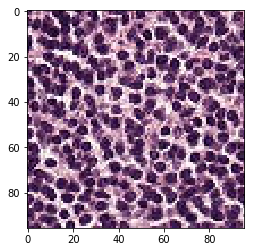

In [5]:
#random samples after preprocessing
print("training images example after preprocessing:")
example, c = next(train_datagen)
for i in range (1,4):
  r = random.randrange(len(c))
  print("class:{}".format(c[r]))
  img = example[r]
  plt.imshow(img)
  plt.show()

print("validation images example after preprocessing:")
example, c = next(validation_datagen)
for i in range (1,4):
  r = random.randrange(len(c))
  print("class:{}".format(c[r]))
  img = example[r]
  plt.imshow(img)
  plt.show()
               
print("test images example after preprocessing:")
example, c = next(test_datagen)
for i in range (1,4):
  r = random.randrange(len(c))
  print("class:{}".format(c[r]))
  img = example[r]
  plt.imshow(img)
  plt.show()              









219062272/219055592 [==============================] - 7s 0us/step

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 2048)         21802784    input_1[0][0]                    
__________________________________________________________________________________________________
resnet152 (Model)               (None, 2048)         58370944    input_1[0][0]                    
__________________________________________________________________________________________________
inception_resnet_v2 (

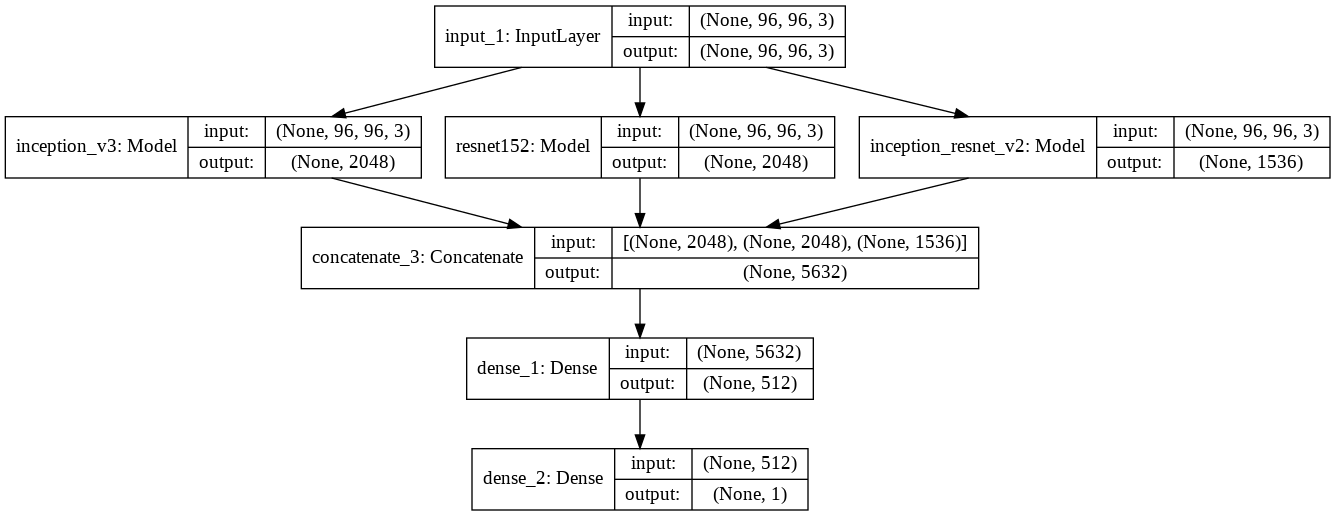

In [6]:
#final_model
inputs = Input(shape=(96,96,3))

inception_v3 = InceptionV3(include_top=False, 
                          weights='imagenet', 
                          input_shape=(96,96,3), 
                          pooling='avg')(inputs)

resnet152 = ResNet152(include_top=False, 
                      weights='imagenet', 
                      input_shape=(96,96,3), 
                      pooling='avg')(inputs)

inception_resnet_v2 = InceptionResNetV2(include_top=False, 
                                        weights='imagenet',
                                        input_shape=(96,96,3),
                                        pooling='avg')(inputs)

outputs = Concatenate(axis=-1)([inception_v3, resnet152, inception_resnet_v2])

outputs = Dense(512, 
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), 
                activation='relu')(outputs)

outputs = Dense(1, 
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), 
                activation='sigmoid')(outputs)

model = Model(inputs, outputs)

model.compile(optimizer=RMSprop(lr=0.0001, decay=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

plot_model(model,
           to_file='/capstone_project/model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB')

In [7]:
#training

model_filepath = proj_dir + "saved_models/weights.{epoch:02d}-{val_acc:.2f}.hdf5"

checkpointer = ModelCheckpoint(filepath=model_filepath, 
                               monitor='val_acc', 
                               verbose=1,
                               mode='auto',
                               save_best_only=True)

earlystopper = EarlyStopping(monitor='val_acc', 
                             min_delta=0.003, 
                             patience=0, 
                             verbose=0, 
                             mode='auto', 
                             restore_best_weights=True)

history = model.fit_generator(train_datagen, 
                              steps_per_epoch=len(train_datagen), 
                              epochs=10, 
                              verbose=1, 
                              callbacks=[checkpointer, earlystopper], 
                              validation_data=validation_datagen, 
                              validation_steps=len(validation_datagen))

Epoch 1/10
1322/1322 [==============================] - 1817s 1s/step - loss: 0.2333 - acc: 0.9078 - val_loss: 0.2467 - val_acc: 0.9270

Epoch 00001: val_acc improved from -inf to 0.92702, saving model to /capstone_project/saved_models/weights.01-0.93.hdf5
Epoch 2/10
1322/1322 [==============================] - 1709s 1s/step - loss: 0.1748 - acc: 0.9344 - val_loss: 0.1641 - val_acc: 0.9447

Epoch 00002: val_acc improved from 0.92702 to 0.94471, saving model to /capstone_project/saved_models/weights.02-0.94.hdf5
Epoch 3/10
1322/1322 [==============================] - 1708s 1s/step - loss: 0.1527 - acc: 0.9437 - val_loss: 0.1554 - val_acc: 0.9495

Epoch 00003: val_acc improved from 0.94471 to 0.94946, saving model to /capstone_project/saved_models/weights.03-0.95.hdf5
Epoch 4/10
1322/1322 [==============================] - 1707s 1s/step - loss: 0.1406 - acc: 0.9486 - val_loss: 0.1397 - val_acc: 0.9523

Epoch 00004: val_acc improved from 0.94946 to 0.95227, saving model to /capstone_proje

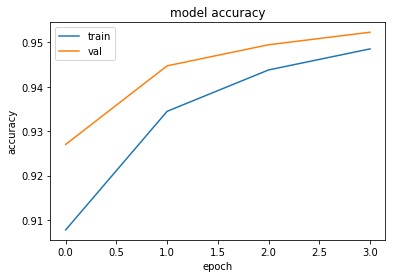

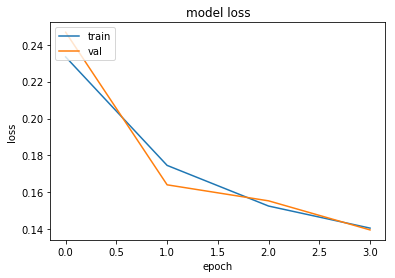

In [10]:
#figures
####### this code is from https://keras.io/visualization/ ######
#acc of training and validation
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("/capstone_project/acc.png")
plt.close()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("/capstone_project/loss.png")
plt.close()

In [11]:
predictions = model.predict_generator(test_datagen, 
                  steps=len(test_datagen), 
                  verbose=1)

439/439 [==============================] - 167s 380ms/step


examples of false negatives with the worst predictions(0):
/capstone_project/data/test/1/0dfd000b079a5f7e979b4fb123424f1e07d7e86d.tif
class: 1
prediction: [0.]


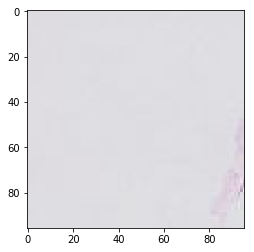

/capstone_project/data/test/1/2be9b013695fd895b98574b689deb9ff1c0ae35d.tif
class: 1
prediction: [0.]


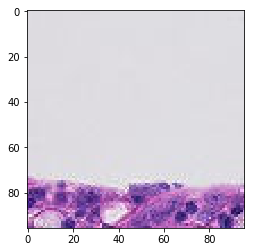

/capstone_project/data/test/1/2e02289a5927b8ee09a383313361f44531badf88.tif
class: 1
prediction: [0.]


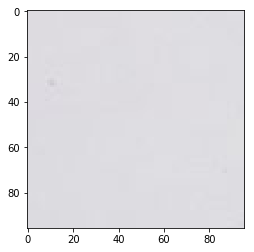

/capstone_project/data/test/1/2fdbc5c6f8576595205eb9c510946c1ca0bf9226.tif
class: 1
prediction: [0.]


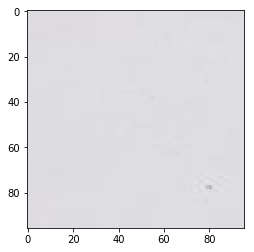

/capstone_project/data/test/1/33622c33a1700d9483fc64e820fb78053150f0f0.tif
class: 1
prediction: [0.]


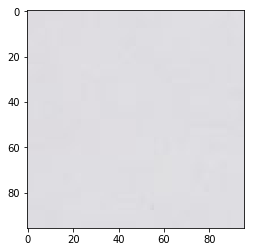

/capstone_project/data/test/1/39f16a9fb750cf01268109bd9254655b1f54f925.tif
class: 1
prediction: [0.]


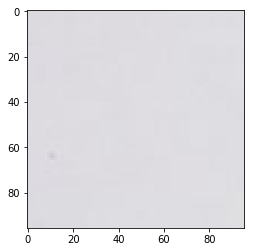

/capstone_project/data/test/1/3ac5497629ae7c70abc983b3509454f158df1c11.tif
class: 1
prediction: [0.]


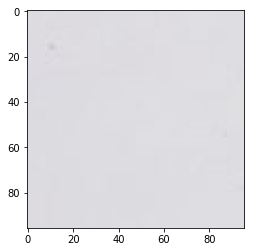

/capstone_project/data/test/1/3e742f4696cbfb4c3923e42395d18a147b8b8293.tif
class: 1
prediction: [0.]


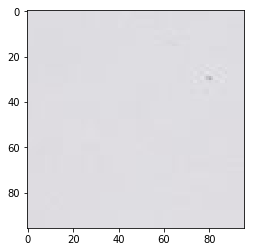

/capstone_project/data/test/1/412bd667b9a9c9b15180d3a3b5593c6ad99a1348.tif
class: 1
prediction: [0.]


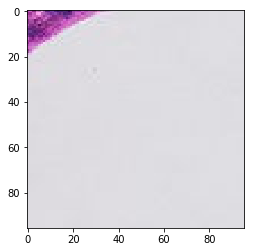

/capstone_project/data/test/1/5f7dea51ef6f3dd6ba7448799919607a81645a35.tif
class: 1
prediction: [0.]


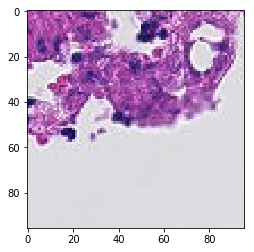

/capstone_project/data/test/1/63ad6ae6d64272c966872859275fd0404e99909a.tif
class: 1
prediction: [0.]


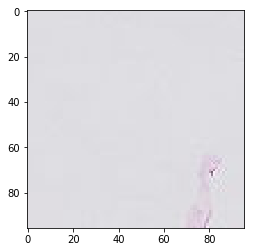

/capstone_project/data/test/1/9b01fb98c4e612c2581d2339777643000893f9bc.tif
class: 1
prediction: [0.]


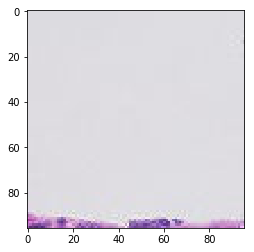

/capstone_project/data/test/1/a0f6b3c9d049ecfa801dfb8937f4dc64553047eb.tif
class: 1
prediction: [0.]


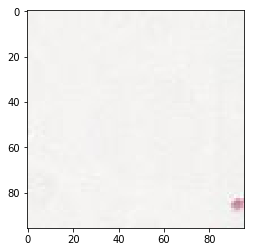

/capstone_project/data/test/1/b9169425361f4b26d890475a0969609db3f500d8.tif
class: 1
prediction: [0.]


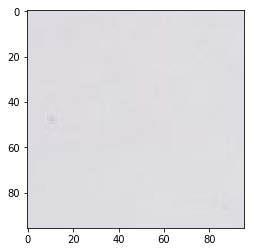

/capstone_project/data/test/1/ec7dc5c19d27aed14ee238c8babafaf28ce2d856.tif
class: 1
prediction: [0.]


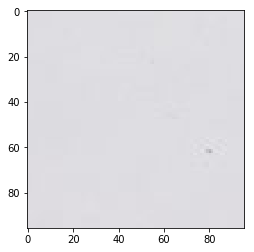

examples of false positives with the worst predictions(~1):
/capstone_project/data/test/0/1a21f3b7892c8240db17ba590496d1b0dfaa1691.tif
class: 0
prediction: [0.99999166]


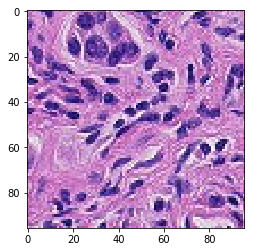

/capstone_project/data/test/0/1dedd495f50f839c56a2dcbfd6c44314c7352e8f.tif
class: 0
prediction: [0.9996458]


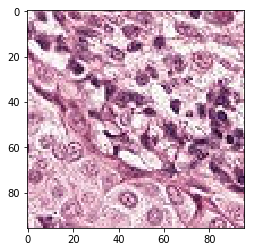

/capstone_project/data/test/0/4eb971bd48c052994608fb7c5a05567052f404fe.tif
class: 0
prediction: [0.99980295]


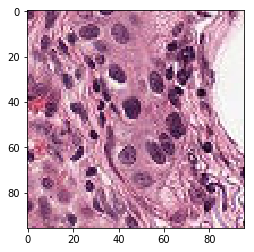

/capstone_project/data/test/0/886c8a5ad78d6d86f8e5bba0f1aabf4507b4a873.tif
class: 0
prediction: [0.9998251]


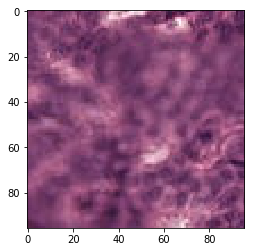

/capstone_project/data/test/0/abd33a987721e7b12e7e3b2ecfda25adeea5c122.tif
class: 0
prediction: [0.9990208]


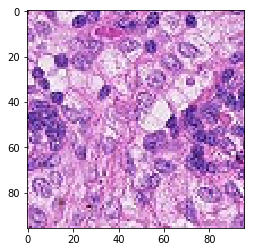

/capstone_project/data/test/0/ac577ff838a7e47abc9802deebc864dc185bccb0.tif
class: 0
prediction: [0.9991556]


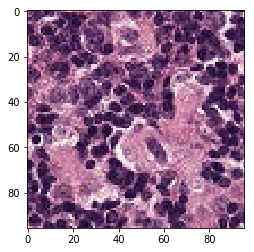

/capstone_project/data/test/0/bffe92ef9f3dbf8f63812187807830b8c51f2c79.tif
class: 0
prediction: [0.99997926]


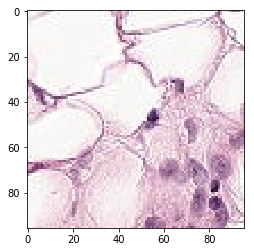

/capstone_project/data/test/0/c42cfdf316662e425de26fb4f27b5f160bed72ae.tif
class: 0
prediction: [0.9996384]


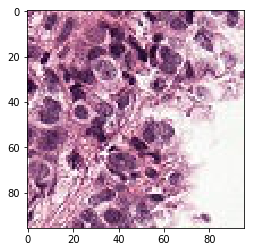

/capstone_project/data/test/0/cd036d4bf84433d2d1b7daba466b21c5f244f965.tif
class: 0
prediction: [0.9995531]


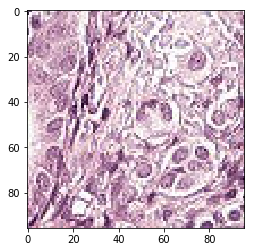

/capstone_project/data/test/0/e7390fd7ce665bea1c3bd6359664c40a6b6f915d.tif
class: 0
prediction: [0.99999505]


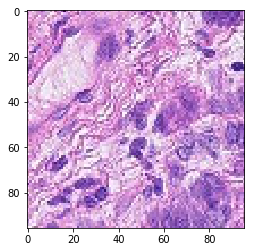

/capstone_project/data/test/0/eaa723de204ae409693c34382ec5a684ba86c1b4.tif
class: 0
prediction: [0.99945205]


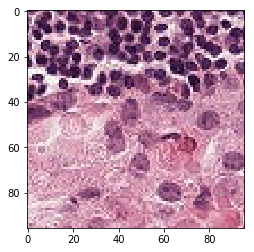

In [67]:
#visualize test results

print("examples of false negatives with the worst predictions(0):")
for i in range(len(predictions)):
  if test_datagen.classes[i] == 1 and predictions[i] == 0:
    print("/capstone_project/data/test/" + test_datagen.filenames[i])
    print("class: {}".format(test_datagen.classes[i]))
    print("prediction: {}".format(predictions[i]))
    img=mpimg.imread("/capstone_project/data/test/" + test_datagen.filenames[i])
    plt.imshow(img)
    plt.show()

print("examples of false positives with very bad predictions(~1):")
for i in range(len(predictions)):
  if test_datagen.classes[i] == 0 and predictions[i] >= 0.999:
    print("/capstone_project/data/test/" + test_datagen.filenames[i])
    print("class: {}".format(test_datagen.classes[i]))
    print("prediction: {}".format(predictions[i]))
    img=mpimg.imread("/capstone_project/data/test/" + test_datagen.filenames[i])
    plt.imshow(img)
    plt.show()
    

In [0]:
predicted_labels = []
for i in range(len(predictions)):
  if predictions[i] >= 0.5:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)

true negative:25890
false positive:332
false negative:2185
true positive:15455


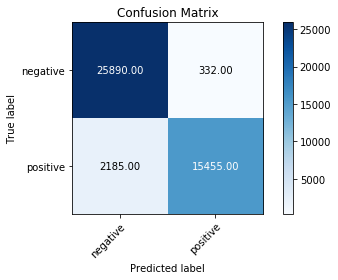

In [29]:
###### this function is from scikit learn Confusion matrix example, I modified it for this project #######
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py ##

# calculationg and ploting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, 
                          title = None,
                          cmap=plt.cm.Blues):
  
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # get tn, fp, fn, tp values from the confusion matrix and print them
    tn, fp, fn, tp = cm.ravel()
    print("true negative:{}\nfalse positive:{}\nfalse negative:{}\ntrue positive:{}".format(tn, fp, fn, tp))

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, tn, fp, fn, tp
  
_, tn, fp, fn, tp = plot_confusion_matrix(test_datagen.classes, 
                                          predicted_labels, classes=["negative", "positive"], 
                                          title="Confusion Matrix")
plt.show()
plt.savefig("/capstone_project/cm.png")
plt.close()

AUC: 0.9838132837860438


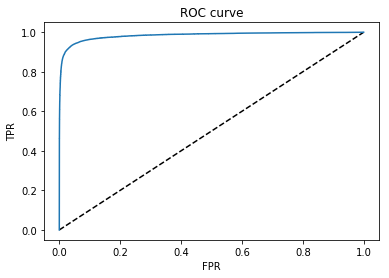

In [42]:
###### this code is from scikit learn examples, I modified it for this project ######
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve ##
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html ##
## https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py ##

# plot the ROC curve and calculating the AUC
fpr, tpr, thresholds = roc_curve(test_datagen.classes, predictions)
AUC = auc(fpr, tpr)
print("AUC: {}".format(AUC))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
plt.savefig("/capstone_project/roc.png")
plt.close()

In [43]:
#calculating accuracy

acc = accuracy_score(test_datagen.classes, predicted_labels)
print("accuracy:{}".format(acc))

accuracy:0.9426154758104965


In [44]:
# calculating Diagnostic odds ratios (DOR) from this formula: (TPR/FPR) / (FNR/TNR) 
DOR = (tp/fp)/(fn/tn)
print("Diagnostic odds ratios (DOR): {}".format(DOR))

Diagnostic odds ratios (DOR): 551.5838410851645
